In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import datetime as dt
import os
import pickle
import sys
import imblearn
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import *
import zipfile
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
import glob
import logging
import datetime
import time

C:\Users\mehta\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv("C:/Users/mehta/Desktop/ADS/Final_Project/Chicago_Crimes_2012_to_2017.csv")

In [3]:
data['Primary Type'].nunique()

33

In [4]:
data['Primary Type'].replace(['NON - CRIMINAL'], ['NON-CRIMINAL'], inplace=True)

In [5]:
data.dropna(subset=['Community Area'], how = 'any', inplace = True)
data.dropna(subset=['Case Number'], how = 'any', inplace = True)
data.dropna(subset=['Ward'], how = 'any', inplace = True)
data.dropna(subset=['District'], how = 'any', inplace = True)
data.dropna(subset=['X Coordinate'], how = 'any', inplace = True)
data.dropna(subset=['Y Coordinate'], how = 'any', inplace = True)
data.dropna(subset=['Latitude'], how = 'any', inplace = True)
data.dropna(subset=['Longitude'], how = 'any', inplace = True)
data.dropna(subset=['Location'], how = 'any', inplace = True)
max_browser = pd.DataFrame(data.groupby('Location Description').size().rename('cnt')).idxmax()[0]
data['Location Description'] = data['Location Description'].fillna(max_browser)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1419591 entries, 0 to 1456713
Data columns (total 23 columns):
Unnamed: 0              1419591 non-null int64
ID                      1419591 non-null int64
Case Number             1419591 non-null object
Date                    1419591 non-null object
Block                   1419591 non-null object
IUCR                    1419591 non-null object
Primary Type            1419591 non-null object
Description             1419591 non-null object
Location Description    1419591 non-null object
Arrest                  1419591 non-null bool
Domestic                1419591 non-null bool
Beat                    1419591 non-null int64
District                1419591 non-null float64
Ward                    1419591 non-null float64
Community Area          1419591 non-null float64
FBI Code                1419591 non-null object
X Coordinate            1419591 non-null float64
Y Coordinate            1419591 non-null float64
Year                    1

In [7]:
data.isnull().sum()

Unnamed: 0              0
ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64

In [8]:
data['Primary Type'] = data['Primary Type'].astype('category')

In [9]:
data['Primary_Label'] = data['Primary Type'].cat.codes

In [10]:
data.tail(20)

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Primary_Label
1456694,6246478,10508650,HZ250022,05/03/2016 05:00:00 PM,078XX S MARSHFIELD AVE,031A,ROBBERY,ARMED: HANDGUN,STREET,False,...,71.0,03,1166708.0,1852625.0,2016,05/10/2016 03:56:50 PM,41.751166,-87.664670,"(41.751166357, -87.664670209)",27
1456695,6246521,10508653,HZ250512,05/03/2016 11:58:00 PM,026XX W LE MOYNE ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,RESIDENTIAL YARD (FRONT/BACK),True,...,24.0,04A,1158381.0,1909870.0,2016,05/10/2016 03:56:50 PM,41.908427,-87.693623,"(41.908426978, -87.693622615)",1
1456696,6247563,10508656,HZ250476,05/03/2016 03:15:00 PM,014XX N OGDEN AVE,1720,OFFENSE INVOLVING CHILDREN,CONTRIBUTE DELINQUENCY OF A CHILD,STREET,False,...,8.0,20,1171322.0,1909588.0,2016,05/10/2016 03:56:50 PM,41.907378,-87.646092,"(41.907378476, -87.64609233)",21
1456697,6247798,10508658,HZ250506,05/03/2016 11:50:00 PM,018XX S KEDZIE AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,...,29.0,26,1155317.0,1890928.0,2016,05/10/2016 03:56:50 PM,41.856510,-87.705387,"(41.856510401, -87.705387422)",23
1456698,6248016,10508659,HZ250499,05/03/2016 11:38:00 PM,038XX S PRINCETON AVE,0460,BATTERY,SIMPLE,CHA PARKING LOT/GROUNDS,False,...,34.0,08B,1174922.0,1879297.0,2016,05/10/2016 03:56:50 PM,41.824178,-87.633775,"(41.82417802, -87.6337748)",2
1456699,6248192,10508661,HZ250344,05/03/2016 08:44:00 PM,070XX S WABASH AVE,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,...,69.0,04B,1177941.0,1858411.0,2016,05/10/2016 03:56:50 PM,41.766797,-87.623332,"(41.766796861, -87.623332025)",2
1456700,6248278,10508662,HZ250477,05/03/2016 08:00:00 AM,057XX S MICHIGAN AVE,5001,OTHER OFFENSE,OTHER CRIME INVOLVING PROPERTY,APARTMENT,False,...,40.0,26,1178135.0,1867058.0,2016,05/10/2016 03:56:50 PM,41.790521,-87.622359,"(41.790520722, -87.622358898)",23
1456701,6248713,10508663,HZ250466,05/03/2016 10:10:00 PM,033XX W MARQUETTE RD,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,APARTMENT,False,...,66.0,17,1155359.0,1859995.0,2016,05/10/2016 03:56:50 PM,41.771625,-87.706062,"(41.771625308, -87.706062047)",28
1456702,6248779,10508664,HZ250486,05/03/2016 11:35:00 PM,083XX S CARPENTER ST,0560,ASSAULT,SIMPLE,RESIDENCE,True,...,71.0,08A,1170770.0,1849485.0,2016,05/10/2016 03:56:50 PM,41.742462,-87.649876,"(41.742462184, -87.649876395)",1
1456703,6248999,10508665,HZ250448,05/03/2016 10:15:00 PM,095XX S LOOMIS ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,...,73.0,14,1168707.0,1841343.0,2016,05/10/2016 03:56:50 PM,41.720164,-87.657669,"(41.720164061, -87.657669427)",6


In [11]:
data['District'].value_counts()

11.0    99972
8.0     94243
6.0     84712
4.0     83590
7.0     82129
25.0    81307
3.0     71575
9.0     69173
12.0    67732
10.0    64744
19.0    64345
5.0     63417
15.0    63155
18.0    61892
1.0     60288
2.0     58717
14.0    51030
16.0    48516
22.0    46243
17.0    40359
24.0    39295
20.0    23130
31.0       26
13.0        1
Name: District, dtype: int64

In [12]:
(data['Primary Type'].map(str) + data['Primary_Label'].map(str)).value_counts()

THEFT30                               322423
BATTERY2                              258942
CRIMINAL DAMAGE6                      152813
NARCOTICS17                           131177
ASSAULT1                               89508
OTHER OFFENSE23                        85362
BURGLARY3                              81670
DECEPTIVE PRACTICE8                    68354
MOTOR VEHICLE THEFT16                  59856
ROBBERY27                              56095
CRIMINAL TRESPASS7                     36429
WEAPONS VIOLATION31                    16983
PUBLIC PEACE VIOLATION26               13015
OFFENSE INVOLVING CHILDREN21           10590
PROSTITUTION24                          7567
CRIM SEXUAL ASSAULT5                    6298
INTERFERENCE WITH PUBLIC OFFICER12      6136
SEX OFFENSE28                           4491
HOMICIDE10                              2590
GAMBLING9                               2211
ARSON0                                  2175
LIQUOR LAW VIOLATION15                  1928
KIDNAPPING

In [13]:
data['Primary Type'].value_counts()

THEFT                                322423
BATTERY                              258942
CRIMINAL DAMAGE                      152813
NARCOTICS                            131177
ASSAULT                               89508
OTHER OFFENSE                         85362
BURGLARY                              81670
DECEPTIVE PRACTICE                    68354
MOTOR VEHICLE THEFT                   59856
ROBBERY                               56095
CRIMINAL TRESPASS                     36429
WEAPONS VIOLATION                     16983
PUBLIC PEACE VIOLATION                13015
OFFENSE INVOLVING CHILDREN            10590
PROSTITUTION                           7567
CRIM SEXUAL ASSAULT                    6298
INTERFERENCE WITH PUBLIC OFFICER       6136
SEX OFFENSE                            4491
HOMICIDE                               2590
GAMBLING                               2211
ARSON                                  2175
LIQUOR LAW VIOLATION                   1928
KIDNAPPING                      

In [14]:
data.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Unnamed: 0,3,89,197,673,911,1108,1130,1801,1868,1891,1935,2150,2193,2279,2477,2847,3023,3088,3242,3264
ID,10508693,10508695,10508697,10508698,10508699,10508702,10508703,10508704,10508709,10508982,10508710,10508715,10508717,10508724,10508728,10508732,10508738,10508741,10508747,10508752
Case Number,HZ250496,HZ250409,HZ250503,HZ250424,HZ250455,HZ250447,HZ250489,HZ250514,HZ250523,HZ250667,HZ250469,HZ250541,HZ250415,HZ250513,HZ250505,HZ250535,HZ250440,HZ250587,HZ250577,HZ250500
Date,05/03/2016 11:40:00 PM,05/03/2016 09:40:00 PM,05/03/2016 11:31:00 PM,05/03/2016 10:10:00 PM,05/03/2016 10:00:00 PM,05/03/2016 10:35:00 PM,05/03/2016 10:30:00 PM,05/03/2016 09:30:00 PM,05/03/2016 04:00:00 PM,05/03/2016 10:30:00 PM,05/03/2016 09:44:00 PM,05/03/2016 11:11:00 PM,05/03/2016 05:30:00 PM,05/03/2016 09:00:00 AM,05/03/2016 10:08:00 PM,05/03/2016 04:00:00 PM,05/03/2016 09:45:00 PM,05/03/2016 10:00:00 PM,05/03/2016 08:00:00 PM,05/03/2016 11:00:00 PM
Block,013XX S SAWYER AVE,061XX S DREXEL AVE,053XX W CHICAGO AVE,049XX W FULTON ST,003XX N LOTUS AVE,082XX S MARYLAND AVE,027XX S STATE ST,002XX E 46TH ST,014XX W DEVON AVE,069XX S ASHLAND AVE,074XX S SOUTH SHORE DR,006XX N WABASH AVE,011XX W JACKSON BLVD,028XX S DR MARTIN LUTHER KING JR DR,016XX N CLAREMONT AVE,072XX S RICHMOND ST,020XX W LE MOYNE ST,055XX S STATE ST,100XX S SANGAMON ST,043XX S ELLIS AVE
IUCR,0486,0486,0470,0460,0820,041A,0460,0460,0460,0486,143A,0486,0890,0820,0810,0486,0810,0313,0910,0486
Primary Type,BATTERY,BATTERY,PUBLIC PEACE VIOLATION,BATTERY,THEFT,BATTERY,BATTERY,BATTERY,BATTERY,BATTERY,WEAPONS VIOLATION,BATTERY,THEFT,THEFT,THEFT,BATTERY,THEFT,ROBBERY,MOTOR VEHICLE THEFT,BATTERY
Description,DOMESTIC BATTERY SIMPLE,DOMESTIC BATTERY SIMPLE,RECKLESS CONDUCT,SIMPLE,$500 AND UNDER,AGGRAVATED: HANDGUN,SIMPLE,SIMPLE,SIMPLE,DOMESTIC BATTERY SIMPLE,UNLAWFUL POSS OF HANDGUN,DOMESTIC BATTERY SIMPLE,FROM BUILDING,$500 AND UNDER,OVER $500,DOMESTIC BATTERY SIMPLE,OVER $500,ARMED: OTHER DANGEROUS WEAPON,AUTOMOBILE,DOMESTIC BATTERY SIMPLE
Location Description,APARTMENT,RESIDENCE,STREET,SIDEWALK,RESIDENCE,STREET,CHA HALLWAY/STAIRWELL/ELEVATOR,RESIDENCE PORCH/HALLWAY,SIDEWALK,STREET,VEHICLE NON-COMMERCIAL,SIDEWALK,OTHER,STREET,STREET,RESIDENCE,STREET,SIDEWALK,STREET,APARTMENT
Arrest,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False


In [15]:
data['Primary Type'].unique()

[BATTERY, PUBLIC PEACE VIOLATION, THEFT, WEAPONS VIOLATION, ROBBERY, ..., PUBLIC INDECENCY, HUMAN TRAFFICKING, CONCEALED CARRY LICENSE VIOLATION, OTHER NARCOTIC VIOLATION, NON-CRIMINAL (SUBJECT SPECIFIED)]
Length: 32
Categories (32, object): [BATTERY, PUBLIC PEACE VIOLATION, THEFT, WEAPONS VIOLATION, ..., HUMAN TRAFFICKING, CONCEALED CARRY LICENSE VIOLATION, OTHER NARCOTIC VIOLATION, NON-CRIMINAL (SUBJECT SPECIFIED)]

In [19]:
data.isnull().sum()

Unnamed: 0              0
ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
Primary_Label           0
dtype: int64

In [20]:
data['Primary Type'].nunique()

32

In [23]:
data['Date'] = pd.to_datetime(data['Date'])

In [44]:
data['Updated On'] = pd.to_datetime(data['Updated On'])

In [24]:
#print("Date Read")
data['Day']=data['Date'].dt.weekday_name
#print("day")
data['Hour']=data['Date'].dt.hour
#print("hour")
data['Month']=data['Date'].dt.month
#print("month")
data['Year'] = data['Date'].dt.year
#print("year")`

In [30]:
del data['Unnamed: 0']

In [34]:
corr = data.corr()

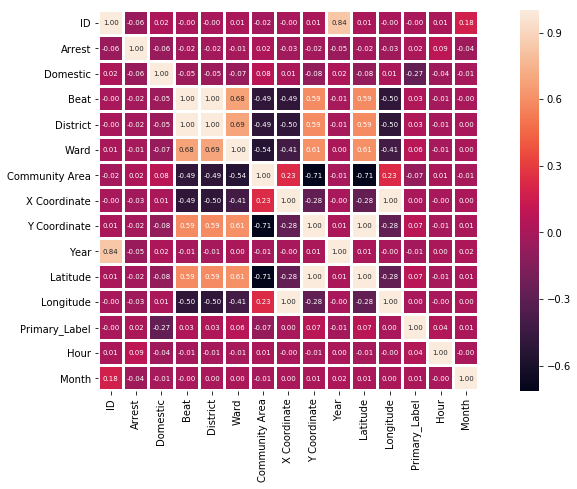

In [35]:
plt.figure(figsize=(15,7))
sns.heatmap(corr, cbar = True, square = True, annot=True, linewidths = 2, fmt='.2f',annot_kws={'size':7}) 
#sns.plt.title('Heatmap of Correlation Matrix')
plt.show()

In [33]:
data.head().T

,0,1,2,3,4
ID,10508693,10508695,10508697,10508698,10508699
Case Number,HZ250496,HZ250409,HZ250503,HZ250424,HZ250455
Date,2016-05-03 23:40:00,2016-05-03 21:40:00,2016-05-03 23:31:00,2016-05-03 22:10:00,2016-05-03 22:00:00
Block,013XX S SAWYER AVE,061XX S DREXEL AVE,053XX W CHICAGO AVE,049XX W FULTON ST,003XX N LOTUS AVE
IUCR,0486,0486,0470,0460,0820
Primary Type,BATTERY,BATTERY,PUBLIC PEACE VIOLATION,BATTERY,THEFT
Description,DOMESTIC BATTERY SIMPLE,DOMESTIC BATTERY SIMPLE,RECKLESS CONDUCT,SIMPLE,$500 AND UNDER
Location Description,APARTMENT,RESIDENCE,STREET,SIDEWALK,RESIDENCE
Arrest,True,False,False,False,False
Domestic,True,True,False,False,True


In [29]:
data.shape

(1419591, 27)

In [45]:
X=data[['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
        'Primary_Label', 'Hour', 'Month'
       ]]
y=data[['Arrest']]

In [ ]:
#RFE

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

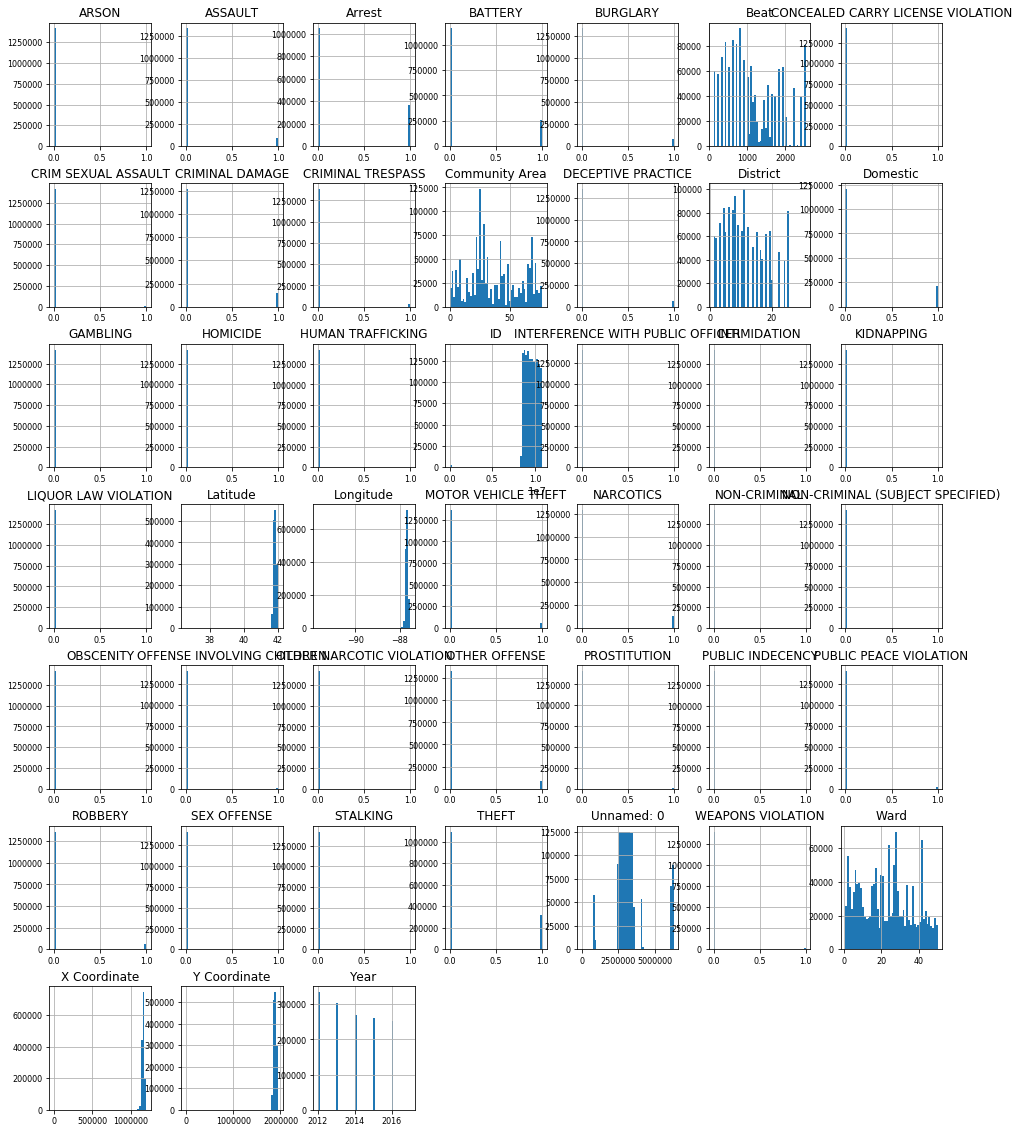

In [16]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

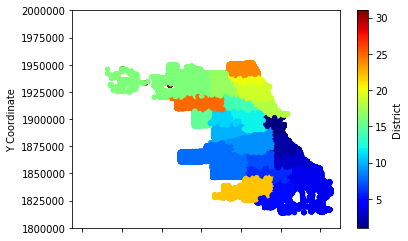

In [29]:
data.plot(kind='scatter',x='X Coordinate', y='Y Coordinate', c='District', cmap=plt.get_cmap('jet'))
plt.xlim(1075000,1210000)
plt.ylim(1800000, 2000000)
plt.figure(figsize=(30,30))

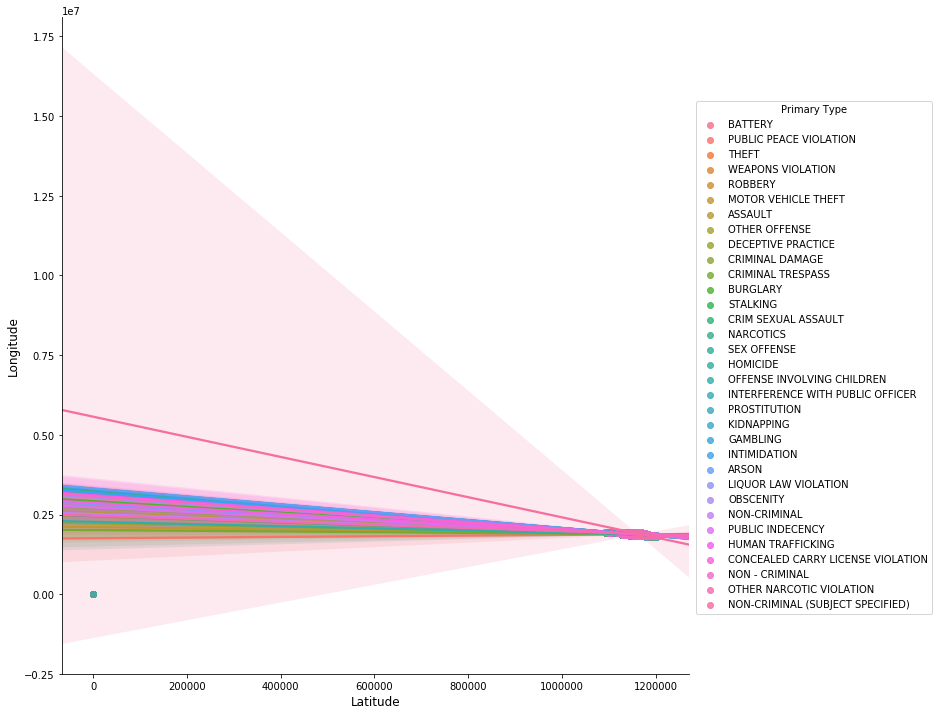

In [30]:
plt.figure(figsize=(50,50))
sns.lmplot(x='X Coordinate', y='Y Coordinate', size=10, hue='Primary Type', data=data, fit_reg=True)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [37]:
data.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Primary_Label', 'Day', 'Hour', 'Month'],
      dtype='object')

In [ ]:
data['Arrest'].value_counts()

In [20]:
def split_dataset(dataset):
    #data = feature_engineering(dataset)
    print("Spliting dataset")
    X=data[['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location', 'Primary_Label', 'Day', 'Hour', 'Month'
       ]]
    y=data[['Arrest']]
    return X, y

In [21]:
def sampling(dataset):
    X,y  = split_dataset(dataset)
    print("Oversampling")
    sm = SMOTE(random_state=12, ratio = 1.0)
    x_res, y_res = sm.fit_sample(X, y)
    return x_res,y_res

In [34]:
def train_test(dataset):
    x_res, y_res = split_dataset(dataset)
    print("Training and testing")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test_split(x_res,
                                                    y_res,
                                                    test_size = .2,
                                                    random_state=12)
    return x_train_res, x_val_res, y_train_res, y_val_res 

In [23]:
def random_forest(dataset):
    print("Random forest pickling")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
    rf = RandomForestClassifier(n_estimators=40, max_depth=10)
    rf.fit(x_train_res, y_train_res)

    filename = 'rf_model.pckl'
    pickle.dump(rf, open(filename, 'wb'))
 
    # some time later...
 
    # load the model from disk
    RandomForest_model = pickle.load(open(filename, 'rb'))
    return RandomForest_model

In [24]:
def k_n(dataset):
    print("KNN pickling")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
# instantiate learning model (k = 3)
    knn = KNeighborsClassifier(n_neighbors=4)

# fitting the model
    knn.fit(x_train_res, y_train_res)
    filename = 'knn_model.pckl'
    pickle.dump(knn, open(filename, 'wb'))
 
    # some time later...
 
    # load the model from disk
    K_nearest_model = pickle.load(open(filename, 'rb'))
    return K_nearest_model

In [25]:
def logReg(dataset):
    print("Log Regression pickling")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
# instantiate learning model (k = 3)
    lr = LogisticRegression()

# fitting the model
    lr.fit(x_train_res, y_train_res)
    filename = 'lr_model.pckl'
    pickle.dump(lr, open(filename, 'wb'))
 
    # some time later...
 
    # load the model from disk
    Log_Reg_model = pickle.load(open(filename, 'rb'))
    return Log_Reg_model

In [26]:
def BernouNb(dataset):
    print("Bernoulli pickling")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
# instantiate learning model (k = 3)
    bnb = BernoulliNB()

# fitting the model
    bnb.fit(x_train_res, y_train_res)
    filename = 'bnb_model.pckl'
    pickle.dump(bnb, open(filename, 'wb'))
 
    # some time later...
 
    # load the model from disk
    Bernoulli_Nb_model = pickle.load(open(filename, 'rb'))
    return Bernoulli_Nb_model

In [27]:
def ex_tr(dataset):
    print("Extra Tree Classifier")

    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
# instantiate learning model (k = 3)
    extr = ExtraTreesClassifier(n_estimators = 50, random_state = 123)

# fitting the model
    extr.fit(x_train_res, y_train_res)
    filename = 'extra_tree_model.pckl'
    pickle.dump(extr, open(filename, 'wb'))
 
    # some time later...
 
    # load the model from disk
    Extra_Tree_model = pickle.load(open(filename, 'rb'))
    return Extra_Tree_model

In [28]:
def models(dataset):
    print("Models")
    randomForest_model = random_forest(dataset)
    K_nearest_model = k_n(dataset)
    Log_Reg_model = logReg(dataset)
    Bernoulli_Nb_model = BernouNb(dataset)
    Extra_Tree_model = ex_tr(dataset)
    #ExtraTreez_model = xtraTree(dataset)
    model = [randomForest_model,
             K_nearest_model,
             Log_Reg_model,
             Bernoulli_Nb_model,
             Extra_Tree_model
             #ExtraTreez_model
             #RandomForestClassifier(n_estimators=40, max_depth=10),
             #KNeighborsClassifier(n_neighbors=4),
             #LogisticRegression(),
             #BernoulliNB(),
             #ExtraTreesClassifier(n_estimators = 500 , random_state = 123)
            ]
    #import os
    #here = os.path.dirname(os.path.abspath(__file__)
    #with open(os.path.join("models.pckl"), 'wb') as filename:
    #    for models in model:
    #        print("loop")
    #        pickle.dump(models, filename)
    #        print("dumped")
    return(model)

In [29]:
def fit_model(model, dataset):
    print("Metrics evaluating")
    x_train_res, x_val_res, y_train_res, y_val_res = train_test(dataset)
    print("Model fitting")
    #model.fit(x_train_res,y_train_res)
    prediction = model.predict(x_val_res)
    f1score = f1_score(y_val_res, prediction)
    accuracy = accuracy_score(y_val_res, prediction)
    cm = confusion_matrix(y_val_res, prediction)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
    
    return f1score,accuracy,tp,fp,fn,tn

In [30]:
def accuracyscore(dataset):
	print("Returning scores")
#    models = []
#    #here = os.path.dirname(os.path.abspath(__file__))
#    with open(os.path.join("models.pckl"), 'rb') as filename:
#        while True:
#            try:
#                print("trying")
#                models.append(pickle.load(filename))
#                print("appended")
#            except EOFError:
#                break
#    print(models)
	model = models(dataset)
	accuracy =[]
	model_name =[]
	f1score = []
	true_positive =[]
	false_positive =[]
	true_negative =[]
	false_negative =[]
	for i in range(0,len(model)):
		f,a,tp,fp,fn,tn = fit_model(model[i],dataset)
		model_name.append(str(model[i]).split("(")[0])
		f1score.append(f)
		accuracy.append(a)
		#matrix.append(cm)
		true_positive.append(tp) 
		false_positive.append(fp)
		true_negative.append(fn) 
		false_negative.append(tn)    
	return model_name,f1score,accuracy,true_positive,false_positive,true_negative,false_negative

In [31]:
def performance_metrics(dataset):
    #models()
    print("Ranking of the models")
    summary2 = accuracyscore(dataset)
    print("Accuracy Score")
    describe1 = pd.DataFrame(summary2[0],columns = {"Model_Name"})
    describe2 = pd.DataFrame(summary2[1],columns = {"F1_score"})
    describe3 = pd.DataFrame(summary2[2], columns ={"Accuracy_score"})
    describe4 = pd.DataFrame(summary2[3], columns ={"True_Positive"})
    describe5 = pd.DataFrame(summary2[4], columns ={"False_Positive"})
    describe6 = pd.DataFrame(summary2[5], columns ={"True_Negative"})
    describe7 = pd.DataFrame(summary2[6], columns ={"False_Negative"})
    des = describe1.merge(describe2, left_index=True, right_index=True, how='inner')
    des = des.merge(describe3,left_index=True, right_index=True, how='inner')
    des = des.merge(describe4,left_index=True, right_index=True, how='inner')
    des = des.merge(describe5,left_index=True, right_index=True, how='inner')
    des = des.merge(describe6,left_index=True, right_index=True, how='inner')
    des = des.merge(describe7,left_index=True, right_index=True, how='inner')
    final_csv = des.sort_values(ascending=False,by="Accuracy_score").reset_index(drop = True)
    return final_csv

In [32]:
def zipping(path,ziph):
    ziph.write(os.path.join('lr_model.pckl'))
    ziph.write(os.path.join('rf_model.pckl'))
    ziph.write(os.path.join('extra_tree_model.pckl'))
    ziph.write(os.path.join('bnb_model.pckl'))
    ziph.write(os.path.join('knn_model.pckl'))

In [ ]:
final_csv = performance_metrics(data)
final_csv.to_csv(str(os.getcwd()) + "/Accuracy_error_metrics.csv")  

Ranking of the models
Returning scores
Models
Random forest pickling
Spliting dataset
Training and testing


C:\Users\mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


KNN pickling
Spliting dataset
Training and testing


C:\Users\mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


Log Regression pickling
Spliting dataset
Training and testing


C:\Users\mehta\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bernoulli pickling
Spliting dataset
Training and testing
Extra Tree Classifier
Spliting dataset
Training and testing


C:\Users\mehta\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
